# Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA



#Read in data.  Zipcode is string to keep leading 0's
raw_data = pd.read_csv('Zillow_data/zhvi_all-homes_zipcode.csv', dtype={'RegionName': object})
raw_data.head(3)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,233265.0,...,1248340.0,1234262.0,1229890.0,1226466.0,1208024.0,1182758.0,1150900.0,1134880.0,1120949.0,1112549.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,211748.0,...,494425.0,493485.0,492514.0,491726.0,491562.0,492618.0,494017.0,494766.0,494546.0,494435.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,245773.0,...,1161916.0,1153259.0,1156287.0,1175142.0,1193746.0,1205413.0,1203165.0,1209735.0,1211403.0,1212520.0


In [2]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30443 entries, 0 to 30442
Columns: 303 entries, RegionID to 2020-06-30
dtypes: float64(294), int64(2), object(7)
memory usage: 70.4+ MB


Imported data as Pandas DataFrame and stored in raw_data variable.  raw_data is in Wide format.

# Cleaning & Preprocessing Functions

In [3]:
def melt_data(df):
    """
    Turn DataFrame from Wide to Long Format
    
    Arguments:
    df -- Pandas DataFrame with dates in Wide format
    
    Return:
    Pandas DataFrame in Long format.
    """
    melted = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'CountyName', 'Metro'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
def clean_data(df):
    """
    Clean DataFrame.  Rename columns, drop unneeded columns, fill missing Metro values, and transform to Long format.
    
    Arguments:
    df -- Pandas DataFrame in Wide format.
    
    Return:
    Cleaned and melted Pandas DataFrame
    """
    #rename RegionName to 'zipcode'
    df.rename(columns={'RegionName': 'zipcode'}, inplace=True)
    
    #drop unneeded columns
    df.drop(columns=['RegionID', 'RegionType', 'StateName', 'SizeRank'], inplace=True)
    
    #Change to long format
    df_long = melt_data(df)
    
    #Non-metro zipcodes now called 'rural'
    df_long.fillna('rural', inplace=True)
    
    return df_long

# Processing & Visualization Functions

In [5]:
def get_codes_data(df, codes):
    """
    Filter DataFrame to show certain zipcodes.
    
    Arguments:
    df -- cleaned Pandas DataFrame in Long format.
    codes -- list of zipcodes to keep in output DataFrame.
    
    Return:
    Pandas DataFrame containing data for the zipcodes contained in 'codes'
    """
    #Filter df to keep data for selected zipcodes
    top_df = df[df['zipcode'].isin(codes)]
    
    #Set time as index
    top_df.set_index('time', inplace=True)
    
    #Drop unneeded columns
    top_df = top_df[['zipcode', 'value']]
    
    return top_df

In [6]:
def split_data_by_code(top_df, codes):
    """
    Split DataFrame into smaller DataFrames, each containing data for one zipcode.
    
    Arguments:
    top_df -- DataFrame containing data for zipcodes you want to separate.
    codes -- list of zipcodes.  A DataFrame will be created for each item in the list.
    
    Return:
    List of DataFrames where each DataFrame corresponds to data from one zipcode contained in 'codes'
    """
    df_list = []
    for i in range(len(codes)):
        df_list.append(top_df.loc[top_df['zipcode'] == codes[i]])
        
    return df_list

In [7]:
def plot_trends(df_list, codes):
    """
    Plot line graphs for DataFrames contained in df_list.
    
    Arguments:
    df_list -- list of DataFrames, each containing data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'df_list'
    
    Return:
    No return value.  Prints a line graph.
    """
    for i in range(len(codes)):
        df_list[i]['value'].plot(label=codes[i], figsize=(15, 6))
        plt.legend()

# Modeling Functions

In [8]:
def get_difference(df_list):
    """
    Perform 2 orders of differencing on each DataFrame in a list of DataFrames.
    
    Arguments:
    df_list -- list of DataFrames, each containing data for one zipcode
    
    Return:
    list of DataFrames, each containing twice differenced data for one zipcode
    """
    df_diff = []
    for code in df_list:
        df_diff.append(code['value'].diff().diff().dropna())

    return df_diff

In [9]:
def plot_diff_trends(diff_list, codes):
    """
    Plot line graphs for DataFrames contained in diff_list.
    
    Arguments:
    diff_list -- list of DataFrames, each containing differenced data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'diff_list'
    
    Return:
    No return value.  Prints a line graph.
    """
    #Graph trends
    for i in range(len(codes)):
        diff_list[i].plot(label=codes[i], figsize=(15, 6))
        plt.legend()

In [10]:
def decompose_graphs(diff_list, codes):
    """
    Plot decomposition graphs for DataFrames contained in diff_list.
    
    Arguments:
    diff_list -- list of DataFrames, each containing differenced data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'diff_list'
    
    Return:
    No return value.  Prints a decomposition graph for each element in diff_list.
    """
    for i in range(len(codes)):
        decomposition = seasonal_decompose(diff_list[i])
        print(codes[i] + ": ")
        fig = plt.figure()
        fig = decomposition.plot()
        fig.set_size_inches(15, 8)

In [11]:
def test_stationarity(timeseries, window):
    """
    Test the stationarity of time series data contained in a DataFrame and print/graph results.
    
    Arguments:
    timeseries -- DataFrame containing time series data
    window -- Integer - the length of time over which to test stationarity
    
    Return:
    N/A.  Prints and graphs results of Dickey Fuller test.
    """

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
def test_station_of_list(diff_list, window):
    """
    Test the stationarity of multiple DataFrames.
    
    Arguments:
    diff_list -- list of DataFrames containing time series data
    window -- Integer - the length of time over which to test stationarity
    
    Return:
    N/A.  Prints and graphs results of Dickey Fuller test for each DataFrame in diff_list.
    """
    for i in range(len(diff_list)):
        test_stationarity(diff_list[i], window)
        

In [13]:
def plot_all_pacf(diff_list, codes):
    """
    Plot PACF graphs for DataFrames contained in diff_list.
    
    Arguments:
    diff_list -- list of DataFrames, each containing data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'diff_list'
    
    Return:
    No return value.  Prints a PACF graph for each element in diff_list.
    """
    for i in range(len(diff_list)):
        plot_pacf(diff_list[i], title= "PACF for Zipcode " + codes[i]);

In [14]:
def plot_all_acf(diff_list, codes):
    """
    Plot ACF graphs for DataFrames contained in diff_list.
    
    Arguments:
    diff_list -- list of DataFrames, each containing data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'diff_list'
    
    Return:
    No return value.  Prints an ACF graph for each element in diff_list.
    """
    for i in range(len(diff_list)):
        plot_acf(diff_list[i], title="ACF for Zipcode " + codes[i]);

In [15]:
def fit_arima(data, model_list, pred_list, ar, diff, ma):
    """
    Fit an ARIMA model on time series data in a DataFrame.  Store model and make predictions.
    
    Arguments:
    data -- DataFrame containing time series data ready for model fitting.
    model_list -- list of models to store the model in.  Can be empty.
    pred_list -- list of predictions to store the predictions in.  Can be empty.
    ar -- Integer - the AutoRegressive term taken as input for the ARIMA model.
    diff -- Integer - the order of differencing term taken as input for the ARIMA model.
    ma -- Integer - the MovingAverage term taken as input for the ARIMA model.
    
    Return:
    model_list -- updated version of the input list containing the new fitted model object.
    pred_list -- updated version of the input list containing a DataFrame of the predictions generated by the model.
    """
    model_data = data.drop('zipcode', axis=1)
    model = ARIMA(model_data, (ar,diff,ma)).fit()
    model_list.append(model)
    pred_list.append(model.predict(typ='levels'))
    
    return model_list, pred_list

# Data Cleaning

In [16]:
df = clean_data(raw_data)

Melted data into long format for proper time series analysis.  Removed unneeded columns and properly named the 'zipcode' column.  Replaced missing 'Metro' values with 'rural'.

# Modeling - Top 5 Codes Since 1996

### Preprocessing & Viz

In [17]:
codes_full_range = ['91108', '90211', '90027', '90266', '94610']
top_full_range = get_codes_data(df, codes_full_range)
fr_list = split_data_by_code(top_full_range, codes_full_range)

Filtered down raw_data to only contain data for specific zipcodes.  The zipcodes are those where median prices have increased the most in the time range 1996-2019.  Then separated out data for each zipcode so that it can be analyzed and graphed separately.  These separated DataFrames are stored in fr_list.

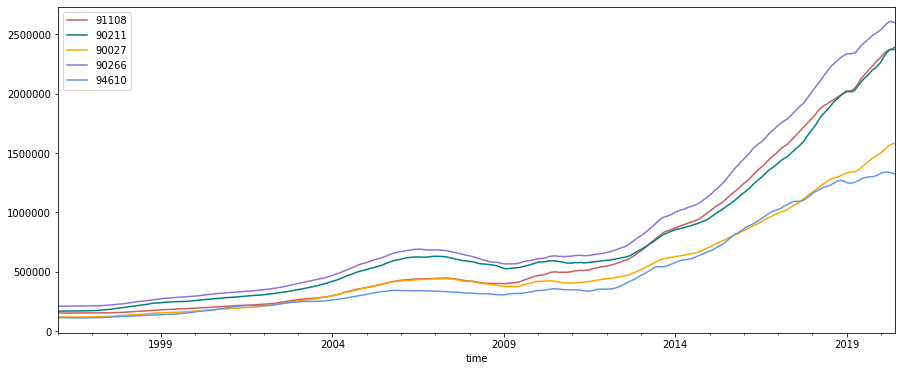

In [18]:
plot_trends(fr_list, codes_full_range)

Visualize how median value changes over time for the top 5 zipcodes.

### Assumptions & Best Parameters

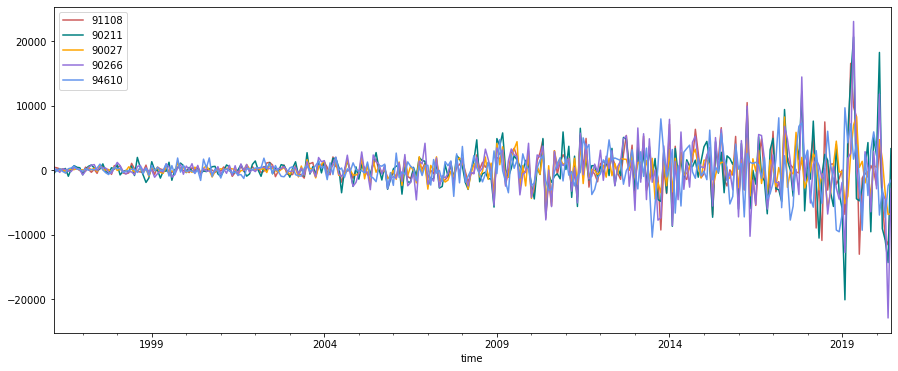

In [19]:
fr_diff = get_difference(fr_list)
plot_diff_trends(fr_diff, codes_full_range)

The unaltered data contained in fr_list was not stationary.  Stationarity is a requirement for most time series modeling and analysis.  To correct this we transform the data using 2 orders of differencing.  This differenced data is stored in fr_diff.  Then, to visually inspect the stationarity, we plot the newly differenced data over time.

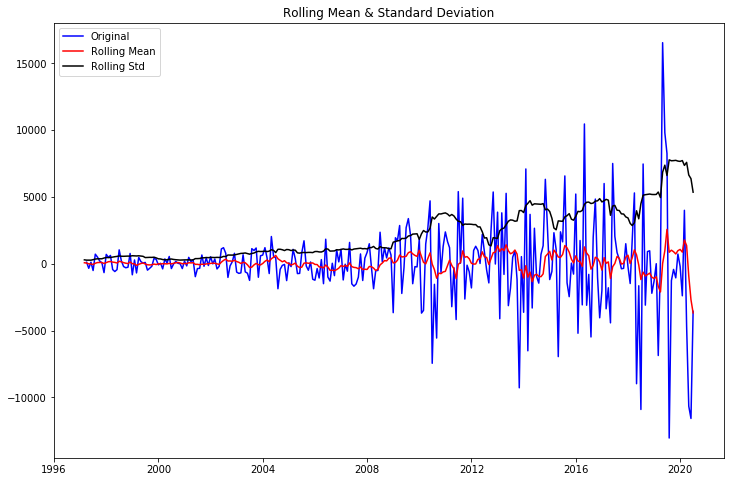

Results of Dickey-Fuller Test:
Test Statistic                  -4.784554
p-value                          0.000058
#Lags Used                      16.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


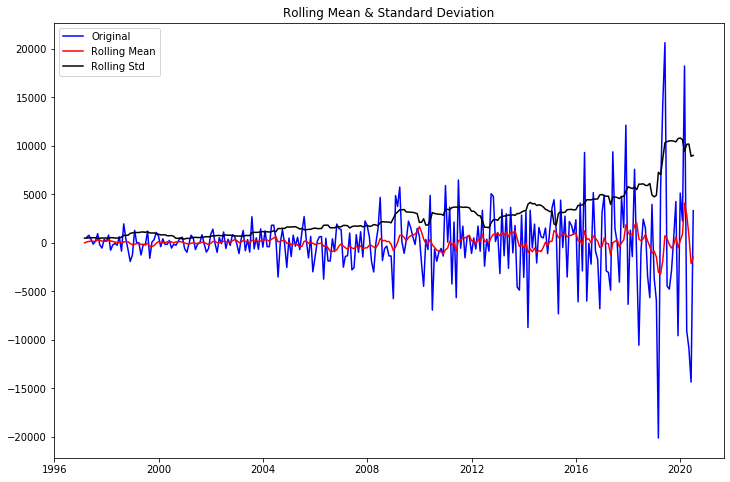

Results of Dickey-Fuller Test:
Test Statistic                  -5.505590
p-value                          0.000002
#Lags Used                      16.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


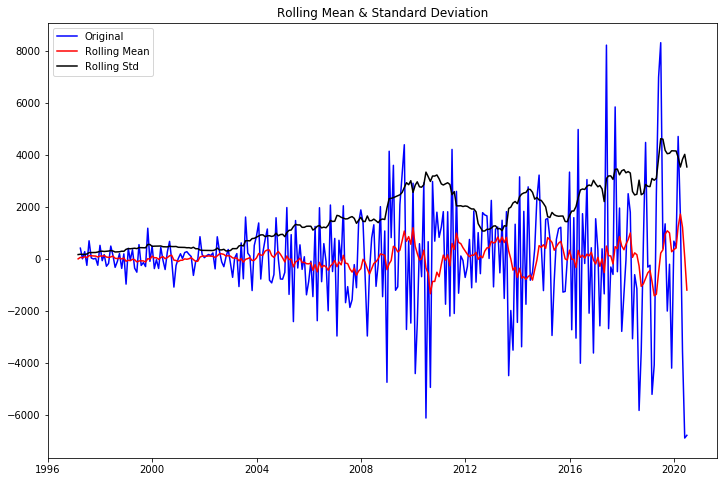

Results of Dickey-Fuller Test:
Test Statistic                  -5.405861
p-value                          0.000003
#Lags Used                      16.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


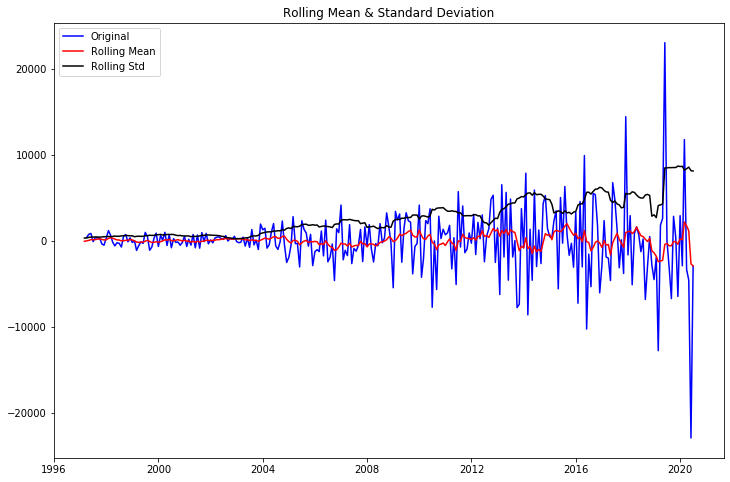

Results of Dickey-Fuller Test:
Test Statistic                  -3.987747
p-value                          0.001476
#Lags Used                      16.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


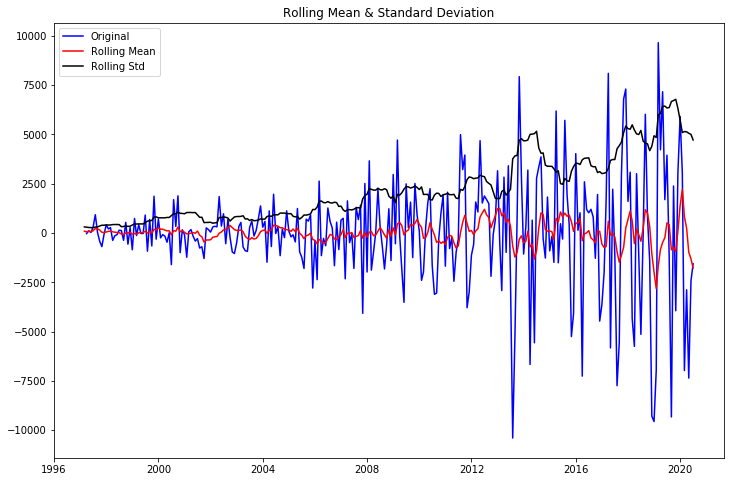

Results of Dickey-Fuller Test:
Test Statistic                  -4.643911
p-value                          0.000107
#Lags Used                      16.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [20]:
test_station_of_list(fr_diff, 12)

The visual inspection of stationarity in the previous step looked promising, but is not enough to make a conclusion on.  In this step we conduct a Dickey-Fuller test for the data of each zipcode contained in fr_diff.  The p-values below the threshold of 0.05 allows us to **reject** the null hypothesis that our data is **not** stationary.

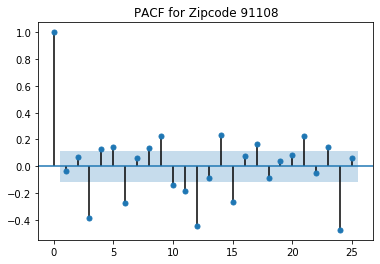

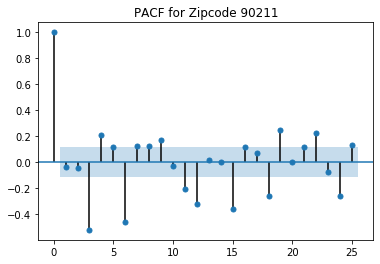

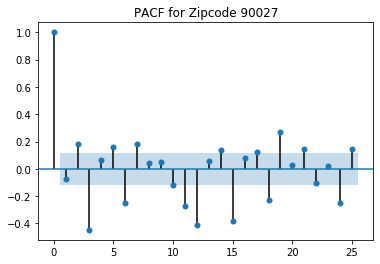

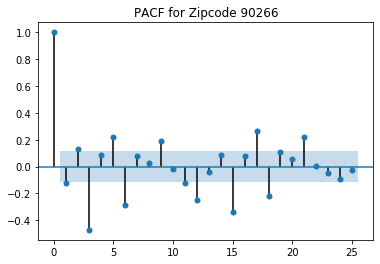

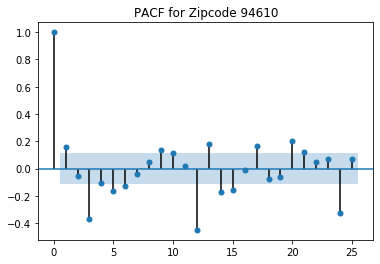

In [21]:
plot_all_pacf(fr_diff, codes_full_range)

These graphs show partial autocorrelation for the differenced data of each zipcode.  The values outside of the confidence interval give us a starting point for AR parameters to try when fitting our ARIMA model.

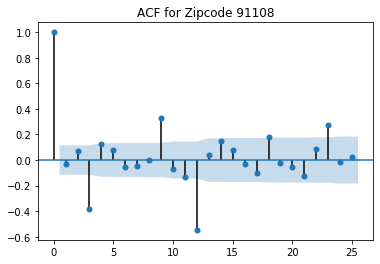

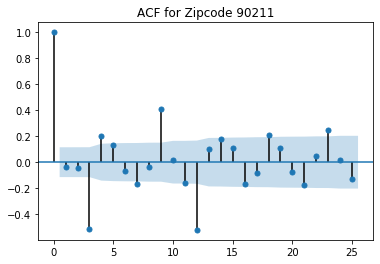

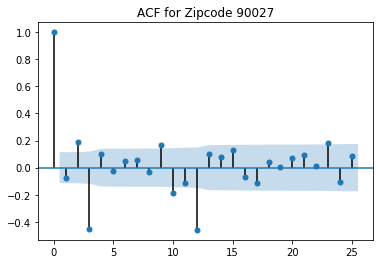

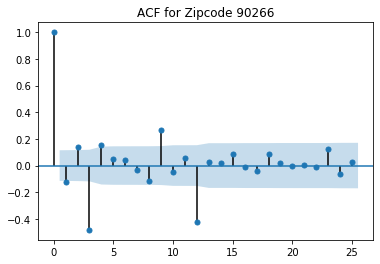

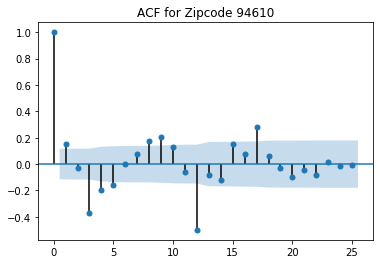

In [22]:
plot_all_acf(fr_diff, codes_full_range)

These graphs show autocorrelation for the differenced data of each zipcode.  The negative values outside of the confidence interval give us a starting point for MA parameters to try when fitting our ARIMA model.

## Model Fitting

## Final Model

## Model & Predictions for 91108

In [26]:
# data_91108 is the dataframe containing all values/dates for zipcode 91108
data_91108 = fr_list[0]
data_91108.drop('zipcode', axis=1, inplace=True)
data_91108

/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,value
time,
1996-01-31,153902.0
1996-02-29,153288.0
1996-03-31,153104.0
1996-04-30,153272.0
1996-05-31,153621.0
...,...
2020-02-29,2334521.0
2020-03-31,2357407.0
2020-04-30,2369633.0


In [29]:
# In this step we are fitting the model and making predictions for the 91108 data
model_91108 = ARIMA(data_91108, (1,2,0)).fit()
predictions_91108 = model_91108.predict(typ='levels')

/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [30]:
#Summary for 91108 Model
model_91108.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.value   No. Observations:                  292
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -2751.322
Method:                       css-mle   S.D. of innovations           2991.098
Date:                Wed, 19 Aug 2020   AIC                           5508.644
Time:                        16:48:54   BIC                           5519.675
Sample:                    03-31-1996   HQIC                          5513.063
                         - 06-30-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -7.8870    169.689     -0.046      0.963    -340.471     324.697
ar.L1.D2.value    -0.0317      0.059     -0.541      0.589      -0.146       0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -31.5899           +0.0000j           31.5899            0.5000
-----------------------------------------------------------------------------
"""

In [35]:
# Predictions from the model
predictions_91108_df = pd.DataFrame(predictions_91108, columns=['value'])
predictions_91108_df

,value
1996-03-31,1.526661e+05
1996-04-30,1.528983e+05
1996-05-31,1.534207e+05
1996-06-30,1.539561e+05
1996-07-31,1.543502e+05
...,...
2020-02-29,2.330591e+06
2020-03-31,2.361930e+06
2020-04-30,2.380432e+06
2020-05-31,2.382188e+06
